In [1]:
import tsconvert
import numpy as np
import matplotlib.pyplot as plt
import sparg
import plotly.express as px

/gpfs/fs1/home/m/mmosmond/mmosmond/.virtualenvs/sparg-revisions/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load newick trees as strings

In [2]:
newickfile="../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr4.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.hap_polarized_relate_extracted_locus1001.newick"

tss = []
with open(newickfile, mode='r') as file:
    for i,line in enumerate(file): 
        if i>0: #skip header
            tree = line.split()[4] #extract newick string only (Relate adds some info beforehand)
            tss.append(tsconvert.from_newick(tree)) #convert to tskit "tree sequence" (only one tree)

we have 10 samples of the branch lengths at this tree

In [26]:
len(tss)

10

take a look at the first

In [3]:
ts0 = tss[0]
ts0.draw_svg(node_labels=dict(), time_scale="log_time", y_axis=True, size=(1e3,1e3))

we can also simplify

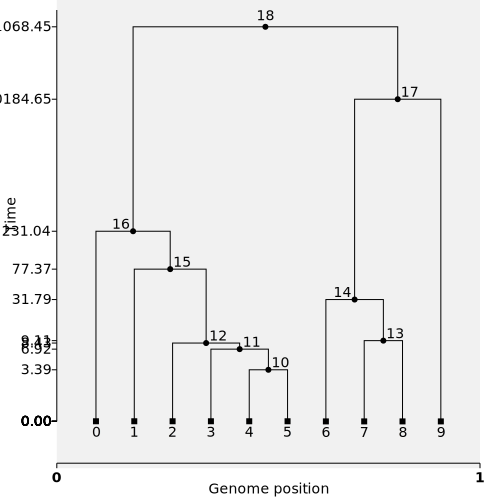

In [4]:
sample_ids = ts0.samples()
samples = np.array([sample_ids[2*i] for i in range(10)])
ts0s = ts0.simplify(samples=samples)
ts0s.draw_svg(size=(500,500), time_scale="log_time", y_axis=True)

and we could simplify all the tree sequences

In [3]:
sample_ids = tss[0].samples() #this is the same for all ts
samples = np.array([sample_ids[2*i] for i in range(100)]) #choose subset
tss_simp = [ts.simplify(samples) for ts in tss]

functions to get the shared times in each tree

In [4]:
def shared_times(tree, samples):
    '''shared time between each pair of samples in tskit tree'''

    T = tree.time(tree.root)
    k = len(samples)
    sts = np.zeros((k,k))
    for i in range(k):
        sts[i,i] = T
        for j in range(i):
            st = T - tree.tmrca(samples[i],samples[j])
            sts[i,j] = st
            sts[j,i] = st

    return sts

In [5]:
def coal_times(ts, samples):
    '''coalescence times in tskit treesequence'''

    cts = [i.time for i in ts.nodes() if i.flags==0]
    
    return sorted(cts)

In [6]:
def times(tss, samples):
    '''shared times and coalescence times in list of one-tree tskit treesequences'''

    stss = []
    ctss = []
    for ts in tss:
        stss.append(shared_times(ts.first(), samples))
        ctss.append(coal_times(ts, samples))

    return stss, ctss

doesn't take too long to do this for the unsimplified treesequences, ie using all the samples

In [7]:
samples = tss[0].samples()
stss, ctss = times(tss, samples=samples)

take a look at the coalescence times across trees

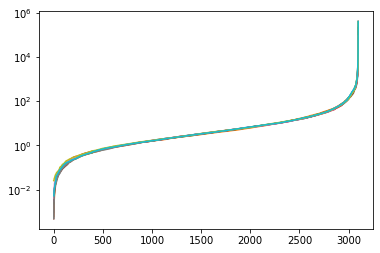

In [7]:
for cts in ctss:
    plt.plot(range(len(cts)),cts)
plt.yscale('log')
plt.show()

so we want people to start with a file of Newick trees from SampleBranchLengths for each locus as well as a coal file from EstimatePopulationSize. sparg will cover the rest of the way to dispersal rates and ancestor locations. we'll leave plotting for the user but also point people to the sparg-ms repo for examples. basically, we want to streamline sparg to the bare necessities, which makes it more flexible.

we will process the newick files as above (with improvements)

we can use our old function for converting the coal file into epochs and Nes

In [8]:
coalfile="../data/cvi_africa_and1001.EVA_2020-10-20.vcf.gz_dip2Norm.vcf.b.gz.vcf_atcgOnly.vcf.gz_chr4.vcf_keep-samples.vcf_biallelic.vcf_imputed.vcf.gz.hap_polarized_relate_extracted.coal"
epochs, Nes = sparg.get_epochs(coalfile)

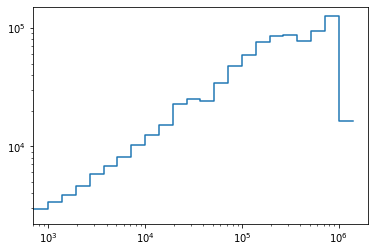

In [18]:
plt.step(epochs, Nes)
plt.xscale('log')
plt.yscale('log')
plt.show()

we can now get the log probability of the coalescence times under a neutral model with this demography

In [9]:
logpcoals = []
for cts in ctss:
    logpcoals.append(sparg.importance_sample._log_coal_density(times=cts, Nes=Nes, epochs=epochs, tCutoff=None))

now we need the locations of all the samples (note this is longitude (x) and latitude (y))

In [12]:
locations = np.loadtxt('../data/sample_locations.txt')
# locations = np.repeat(locations, 2, axis=0) #repeat as every individual has 2 genomes

In [13]:
with_locations = np.unique(np.where(locations!=0))
without_locations = np.unique(np.where(locations==0)) #4 1001g samples do not have locations

and now we're all set to run some inferences

though first we oughta do some checks, and make sure we have the right locations

In [21]:
lons = locations[with_locations,0]
lats = locations[with_locations,1]

In [22]:
fig = px.scatter_geo(lat=lats, lon=lons)
fig.show()

and also that this aligns with the order in the shared_times matrix

In [27]:
stss[0][-3:,:][:,-3:]

array([[81068.454527, 81067.539264, 81067.539264],
       [81067.539264, 81068.454527, 81068.316349],
       [81067.539264, 81068.316349, 81068.454527]])

/tmp/ipykernel_105136/1654471314.py:1: RuntimeWarning:

divide by zero encountered in log



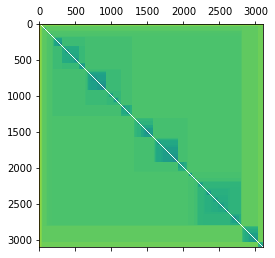

In [54]:
plt.matshow(np.log(np.max(stss[0]) - stss[0]), aspect='auto')
plt.show()

In [51]:
np.std(stss[0])

7076.046503992669

In [41]:
np.mean(stss[0])

79851.87673465953

In [42]:
np.min(stss[0])

0.0

In [43]:
np.max(stss[0])

81068.45452700001

In [44]:
np.median(stss[0])

80604.66276899997

start by using just one tree to get analytical estimate

In [21]:
mles = []
for sts in stss:
    mle=sparg.mle(locations=locations[with_locations],
                  shared_time=sts[with_locations,:][:,with_locations])
    mles.append(mle)

In [25]:
np.median(mles, axis=0)

array([[46.30139608,  2.97950889],
       [ 2.97950889,  2.29691488]])

this could be right, lots of east-west movement. We'll want to filter samples to see how robust this is.

now ...

In [81]:
mle_inf = sparg.estimate(locations=locations[with_locations], 
                         shared_times=[[stss[0][with_locations,:][:,with_locations]]], 
                         samples=[[samples[with_locations]]], 
                         x0=[1,1,0], 
                         important=False)
mle_inf

searching for maximum likelihood parameters...


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1546)

In [27]:
x0 = [SIGMA_disp, SIGMA_disp, 0, 0.002] #initial guess for parameters (sd in x, sd in y, correlation bw x and y, branching rate under Yule model)
bnds = ((1e-6,None), (1e-6,None), (-0.99,0.99), (1e-6,None)) # bounds on the parameters (eg to keep the sd's positive)
scale_phi = 100 #we scale the branching rate and look for the MLE of phi * scale_phi, so that all paramters have more similar variance (which speeds up the optimizer)  

NameError: name 'SIGMA_disp' is not defined

In [37]:
stss[0].shape

(3100, 3100)

In [39]:
len(tss[0].samples())

3100

In [40]:
sparg.estimate?

Signature:
sparg.estimate(
    locations,
    shared_times,
    samples,
    x0,
    bnds=None,
    important=True,
    coal_times=None,
    logpcoals=None,
    scale_phi=1,
    tCutoff=None,
    tsplits=[],
    method='L-BFGS-B',
    options=None,
    n=None,
)
Docstring:
Numerically estimate maximum likelihood dispersal rate (and possibly branching rate) given sample locations and processed trees.

Parameters:
    locations (array-like): Locations of samples. An n x d array, where n is the number of samples and d is the number of spatial dimensions.
    shared_times (array-like): Shared times between sample lineages. An l x m x s_i x n_j x n_j array, where l is the number of loci, m is the number of sampled trees per locus, s_i is the number of subtrees of tree i, and n_j is the number of samples in subtree j
    samples (array-like): The placement of sample nodes in shared_times, to connect the shared times with the sample locations. Same shape as shared_times.   
    x0 (array-like